In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, GRU, Activation
from keras.callbacks import TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../train.csv')
print(df.shape)
df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df_train = df.copy()
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_train['year'] = pd.DatetimeIndex(df_train['datetime']).year
df_train['month'] = pd.DatetimeIndex(df_train['datetime']).month
# df_train['week'] = pd.DatetimeIndex(df_train['datetime']).week
df_train['day'] = pd.DatetimeIndex(df_train['datetime']).day
df_train['dayofweek'] = pd.DatetimeIndex(df_train['datetime']).dayofweek
df_train['hour'] = pd.DatetimeIndex(df_train['datetime']).hour
y_casual = df_train['casual'].copy()
y_registered = df_train['registered'].copy()
df_train = df_train.drop(['casual','registered','count'], axis=1)
x_casual = df_train.copy()
x_casual = x_casual.drop('datetime', axis=1)
x_registered = df_train.copy()
x_registered = x_registered.drop('datetime', axis=1)
cr_w_from = 7
cr_w_to = 23
cr_nw_from = 10
cr_nw_to = 19
rr_w_from1 = 7
rr_w_to1 = 9
rr_w_from2 = 12
rr_w_to2 = 21
rr_nw_from = 8
rr_nw_to = 23
x_casual['casual_rush'] = x_casual[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  cr_w_from <= x['hour'] <= cr_w_to)
        or (x['workingday'] == 0 and  cr_nw_from <= x['hour'] <= cr_nw_to)], axis = 1)
x_registered['registered_rush'] = x_registered[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
#         (x['workingday'] == 1 and  rr_w_from1 <= x['hour'] <= rr_w_to2)
        (x['workingday'] == 1 and  (rr_w_from1 <= x['hour'] <= rr_w_to1 or rr_w_from2 <= x['hour'] <= rr_w_to2))
        or (x['workingday'] == 0 and rr_nw_from <= x['hour'] <= rr_nw_to)], axis = 1)
print(x_casual.shape, x_registered.shape)
x_casual.head()

(10886, 14) (10886, 14)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour,casual_rush
0,1,0,0,1,9.84,14.395,81,0.0,2011,1,1,5,0,0
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,5,1,0
2,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,5,2,0
3,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,5,3,0
4,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,5,4,0


Reshape functions

In [4]:
def reshape_data(x, y, ts=1):
    dataX = np.zeros((x.shape[0]-ts, ts, x.shape[1]))
    dataY = np.zeros((len(y)-ts))
    for i in np.arange(len(y)-ts):
        dataX[i] = x[i:(i+ts)]
        dataY[i] = y[i + ts]
    return np.array(dataX), np.array(dataY)

def reshape_pred(x, ts=1):
    dataX = np.zeros((x.shape[0]-ts,ts,x.shape[1]))
    for i in np.arange(len(x)-ts):
        dataX[i] = x[i:(i+ts)]
    return dataX

Train models

In [5]:
# REGISTERED
X = x_registered.values
Y = y_registered.values
n_features = X.shape[1]
time_steps_reg = 24
scaler_reg = StandardScaler()
X = scaler_reg.fit_transform(X)
# X = X.reshape(X.shape[0], time_steps, n_features)
X, Y = reshape_data(X, Y, time_steps_reg)
def model_reg():
    model = Sequential()
    model.add(GRU(100, input_shape=(time_steps_reg, n_features), return_sequences=True, activation='relu'))
    model.add(GRU(100, input_shape=(time_steps_reg, n_features), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='RMSprop')
    return model
kr_registered = KerasRegressor(build_fn=model_reg, nb_epoch=100, batch_size=5, verbose=2)
%time kr_registered.fit(X, Y, callbacks=[TensorBoard( \
            log_dir='logs/reg_gru2dense4_ts'+str(time_steps_reg)+'_'+datetime.now().strftime("%Y%m%d-%H%M"))])

# CASUAL
time_steps_cas = 1
# X = x_casual.values
# Y = y_casual.values
# n_features = X.shape[1]
# scaler_cas = StandardScaler()
# X = scaler_cas.fit_transform(X)
# X, Y = reshape_data(X, Y, time_steps_cas)
# def model_cas():
#     model = Sequential()
#     model.add(GRU(100, input_shape=(time_steps_cas, n_features), return_sequences=True, activation='relu'))
#     model.add(GRU(100, input_shape=(time_steps_cas, n_features), activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(1))
#     model.add(Activation('linear'))
#     model.compile(loss='mean_squared_error', optimizer='RMSprop')
#     return model
# kr_casual = KerasRegressor(build_fn=model_cas, nb_epoch=100, batch_size=5, verbose=2)
# %time kr_casual.fit(X, Y, callbacks=[TensorBoard( \
#             log_dir='logs/cas_gru2dense4_ts'+str(time_steps_cas)+'_'+datetime.now().strftime("%Y%m%d-%H%M"))])

Epoch 1/100
102s - loss: 7817.5347
Epoch 2/100
98s - loss: 2926.8637
Epoch 3/100
97s - loss: 2199.5882
Epoch 4/100
98s - loss: 1798.6483
Epoch 5/100
98s - loss: 1568.3617
Epoch 6/100
97s - loss: 1410.5268
Epoch 7/100
98s - loss: 1341.3530
Epoch 8/100
97s - loss: 1193.3949
Epoch 9/100
96s - loss: 1132.6403
Epoch 10/100
98s - loss: 1090.7259
Epoch 11/100
102s - loss: 1065.9480
Epoch 12/100
97s - loss: 1003.1280
Epoch 13/100
97s - loss: 920.0298
Epoch 14/100
97s - loss: 909.2819
Epoch 15/100
97s - loss: 855.8700
Epoch 16/100
97s - loss: 816.3281
Epoch 17/100
97s - loss: 783.0753
Epoch 18/100
95s - loss: 735.5509
Epoch 19/100
95s - loss: 720.1421
Epoch 20/100
95s - loss: 701.8462
Epoch 21/100
95s - loss: 695.1672
Epoch 22/100
95s - loss: 654.6218
Epoch 23/100
95s - loss: 642.2356
Epoch 24/100
95s - loss: 607.8551
Epoch 25/100
95s - loss: 590.7864
Epoch 26/100
95s - loss: 575.0203
Epoch 27/100
95s - loss: 569.2255
Epoch 28/100
95s - loss: 558.3250
Epoch 29/100
95s - loss: 536.8301
Epoch 30/

## Prediction

In [6]:
df_test = pd.read_csv('../test.csv')
print(df_test.shape)
df_test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [50]:
# df1 = df.drop(['casual','registered','count'], axis=1)
# df1['datetime'] = pd.to_datetime(df1['datetime'])
# dft = df_test.copy()
# for year in [2011,2012]:
#     for i in np.arange(1,13):
#         m = str(i) if i>9 else '0'+str(i)
#         insert_index = dft[dft['datetime'] == str(year)+'-'+m+'-20 00:00:00'].index[0]
#         line = df1[(df1['datetime'] >= str(year)+'-'+m+'-19 '+str(24-time_steps)) & (df1['datetime'] <= str(year)+'-'+m+'-19 23')]
#         dft = pd.concat([dft.ix[:insert_index-1], line, dft.ix[insert_index:]]).reset_index(drop=True)
# # dft[insert_index-2:insert_index+2]
# dft.shape

line = df_train[df_train['datetime'] == str(2011)+'-01-18 23']
insert_index = 0
t_registered = pd.concat([t_registered.ix[:insert_index-1], line, t_registered.ix[insert_index:]]).reset_index(drop=True)
t_registered.shape
# insert_index = t_registered[t_registered['datetime'] == str(2011)+'-10-19 00:00:00'].index[0]
# line = df_train[df_train['datetime'] == str(2011)+'-10-18 23']
# t_registered = pd.concat([t_registered.ix[:insert_index-1], line, t_registered.ix[insert_index:]]).reset_index(drop=True)
# t_registered.shape

# df_train[(df_train['datetime'] >= str(2011)+'-10-19 '+str(24-time_steps_reg).zfill(2)) & 
#                         (df_train['datetime'] <= str(2011)+'-10-19 23')]
# for year in [2011,2012]:
#     for i in np.arange(1,13):
#         m = str(i).zfill(2)
#         insert_index = t_registered[t_registered['datetime'] == str(year)+'-'+m+'-20 00:00:00'].index[0]
#         print(df_train[(df_train['datetime'] >= str(year)+'-'+m+'-19 '+str(24-time_steps_reg).zfill(2)) & 
#                         (df_train['datetime'] <= str(year)+'-'+m+'-19 23')].shape)
# #         t_registered = pd.concat([t_registered.ix[:insert_index-1], line, t_registered.ix[insert_index:]]).reset_index(drop=True)

(7069, 14)

In [51]:
# dft = df_test.copy()
# dft['datetime'] = pd.to_datetime(dft['datetime'])
# dft['year'] = pd.DatetimeIndex(dft['datetime']).year
# dft['month'] = pd.DatetimeIndex(dft['datetime']).month
# # dft['week'] = pd.DatetimeIndex(dft['datetime']).week
# dft['day'] = pd.DatetimeIndex(dft['datetime']).day
# dft['dayofweek'] = pd.DatetimeIndex(dft['datetime']).dayofweek
# dft['hour'] = pd.DatetimeIndex(dft['datetime']).hour
# t_casual = dft.copy()
# t_registered = dft.copy()
# for year in [2011,2012]:
#     for i in np.arange(1,13):
#         m = str(i).zfill(2)
#         insert_index = t_casual[t_casual['datetime'] == str(year)+'-'+m+'-20 00:00:00'].index[0]
#         line = df_train[(df_train['datetime'] >= str(year)+'-'+m+'-19 '+str(24-time_steps_cas).zfill(2)) & 
#                         (df_train['datetime'] <= str(year)+'-'+m+'-19 23')]
#         t_casual = pd.concat([t_casual.ix[:insert_index-1], line, t_casual.ix[insert_index:]]).reset_index(drop=True)
#         insert_index = t_registered[t_registered['datetime'] == str(year)+'-'+m+'-20 00:00:00'].index[0]
#         line = df_train[(df_train['datetime'] >= str(year)+'-'+m+'-19 '+str(24-time_steps_reg).zfill(2)) & 
#                         (df_train['datetime'] <= str(year)+'-'+m+'-19 23')]
#         t_registered = pd.concat([t_registered.ix[:insert_index-1], line, t_registered.ix[insert_index:]]).reset_index(drop=True)
t_casual = t_casual.drop('datetime', axis=1)
t_registered = t_registered.drop('datetime', axis=1)
t_casual['casual_rush'] = t_casual[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  cr_w_from <= x['hour'] <= cr_w_to)
        or (x['workingday'] == 0 and  cr_nw_from <= x['hour'] <= cr_nw_to)], axis = 1)
t_registered['registered_rush'] = t_registered[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  (rr_w_from1 <= x['hour'] <= rr_w_to1 or rr_w_from2 <= x['hour'] <= rr_w_to2))
        or (x['workingday'] == 0 and rr_nw_from <= x['hour'] <= rr_nw_to)], axis = 1)
print(t_casual.shape, t_registered.shape)
t_registered.head()

(6517, 14) (7069, 14)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour,registered_rush
0,1,0,1,2,9.02,13.635,93,0.0000,2011,1,18,1,23,0
1,1,0,1,2,9.02,13.635,93,0.0000,2011,1,19,2,0,0
2,1,0,1,3,9.02,11.365,93,8.9981,2011,1,19,2,1,0
3,1,0,1,3,9.02,11.365,93,8.9981,2011,1,19,2,2,0
4,1,0,1,3,9.02,11.365,93,8.9981,2011,1,19,2,4,0


In [10]:
df_pred_casual = pd.read_csv('pred_casual_ts1.csv')
test_pred_casual = df_pred_casual['count'].values

In [52]:
# t_casual = scaler_cas.fit_transform(t_casual)
# t_registered = scaler_reg.fit_transform(t_registered)
# t_casual = t_casual.reshape(t_casual.shape[0], time_steps, n_features)
# t_casual = reshape_pred(t_casual, time_steps)
# t_registered = t_registered.reshape(t_registered.shape[0], time_steps, n_features)
# t_registered = reshape_pred(t_registered, time_steps)
t_cas = np.zeros((t_casual.shape[0]-(24*time_steps_cas), time_steps_cas, t_casual.shape[1]))
t_reg = np.zeros((t_registered.shape[0]-(24*time_steps_reg), time_steps_reg, t_registered.shape[1]))
cc = 0
cr = 0
for year in [2011,2012]:
    for i in np.arange(1,13):
#         rs = reshape_pred(t_casual[(t_casual['year']==year) & (t_casual['month']==i)].values, time_steps_cas)
#         cc += len(rs)
#         t_cas[cc-len(rs):cc] = rs
        rs = reshape_pred(t_registered[(t_registered['year']==year) & (t_registered['month']==i)].values, time_steps_reg)
        cr += len(rs)
        t_reg[cr-len(rs):cr] = rs
# t_cas_scaled = np.zeros((t_cas.shape))
t_reg_scaled = np.zeros((t_reg.shape))
for i in np.arange(len(t_cas)):
#     t_cas_scaled[i] = scaler_cas.transform(t_cas[i])
    t_reg_scaled[i] = scaler_reg.transform(t_reg[i])
# test_pred_casual = kr_casual.predict(t_cas_scaled)
# test_pred_casual[test_pred_casual < 0] = 0
test_pred_registered = kr_registered.predict(t_reg_scaled)
test_pred_registered[test_pred_registered < 0] = 0
test_pred = test_pred_casual + test_pred_registered
str_prediction = "datetime,count\n"
for i in range(0, len(test_pred)):
    datetime = df_test['datetime'][i]
    pred = int(round(test_pred[i]))
    str_prediction += "{},{}\n".format(datetime, pred)
f = open('pred_keras_gru.csv','w')
f.write(str_prediction)
f.close()

In [105]:
str_prediction = "datetime,count\n"
for i in range(0, len(test_pred_casual)):
    datetime = df_test['datetime'][i]
    pred = test_pred_casual[i]
    str_prediction += "{},{}\n".format(datetime, pred)
f = open('pred_casual_ts1.csv','w')
f.write(str_prediction)
f.close()

In [142]:
str_prediction = "datetime,count\n"
for i in range(0, len(test_pred_registered)):
    datetime = df_test['datetime'][i]
    pred = test_pred_registered[i]
    str_prediction += "{},{}\n".format(datetime, pred)
f = open('pred_registered_ts18.csv','w')
f.write(str_prediction)
f.close()

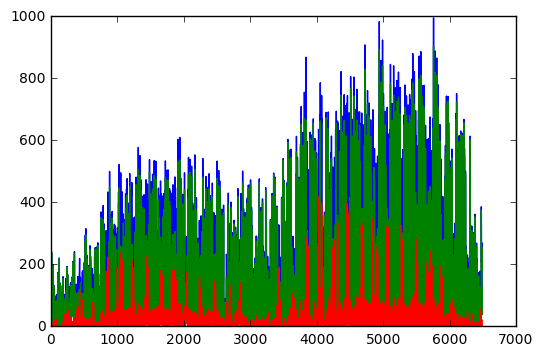

In [53]:
plt.plot(test_pred)
plt.plot(test_pred_registered)
plt.plot(test_pred_casual)

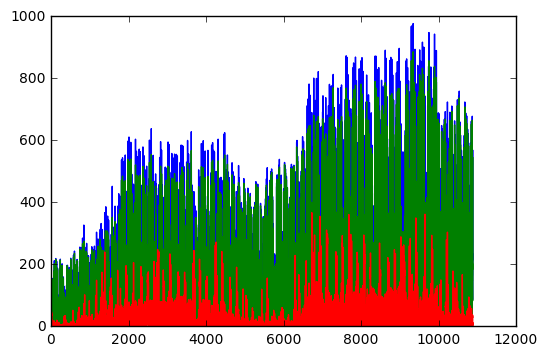

In [21]:
plt.plot(df['count'])
plt.plot(df['registered'])
plt.plot(df['casual'])